In [1]:
import os
import sys
import pandas as pd
sys.path.insert(0, "../../")
from src.text.epu import EPU

In [2]:
target_folder = sys.path[0] + "/data/text/samoa/"
target_files = [target_folder + file for file in os.listdir(target_folder) 
                if "news" in file]

In [3]:
climate_list = [
    "climate", "climate change", "climate risk",
    "carbon dioxide", "CO2", "greenhouse", "emissions", "greenhouse gas emissions", 
    "global warming","green energy", "renewable energy", "environmental"
]

In [8]:
additional_terms = [
    "job",
    'full-time', 'part-time', 'temporary', 'contractual', 'freelance',
    'remote work', 'gig economy', 'employed', 'unemployed', 'underemployed',
    'self-employed', 'jobless', 'retired', 'disabled worker', 'recruitment',
    'hiring process', 'resume', 'cv', 'cover letter', 'job interview',
    'job application', 'career advancement', 'promotion', 'termination',
    'layoffs', 'workplace culture', 'employee benefits', 'health insurance',
    'retirement plans', 'sick leave', 'maternity leave', 'paternity leave',
    'flexible hours', 'work-life balance', 'occupational safety', 'skills',
    'qualifications', 'education level', 'experience', 'training',
    'certification', 'soft skills', 'hard skills', 'labor force', 'job market',
    'employment rate', 'unemployment rate', 'job creation', 'job vacancies',
    'labor laws', 'minimum wage'
]

samoa_stats = pd.DataFrame()
for file in target_files:
    samoa = EPU(file, additional_terms=additional_terms)
    samoa.get_epu_category(subset_condition="date >= '2016-01-01'")
    samoa_stat = samoa.get_epu_stats(cutoff="2020-01-01")
    if samoa_stats.empty:
        samoa_stats = samoa_stat
    else:
        samoa_stats = samoa_stats.merge(samoa_stat, how="outer", on="date")

In [9]:
samoa_stats = samoa_stats[samoa_stats.date >="2016-01-01"].fillna(0)
samoa_stats["news_count_total"] = samoa_stats[["news_count_x", "news_count_y"]].sum(axis=1)
samoa_stats["weight_x"] = samoa_stats["news_count_x"]/samoa_stats["news_count_total"]
samoa_stats["weight_y"] = samoa_stats["news_count_y"]/samoa_stats["news_count_total"]

In [10]:
samoa_stats["z_score"] = [
    x * x_w + y * y_w for x, x_w, y, y_w in
    zip(samoa_stats["z_score_x"], samoa_stats["weight_x"],
        samoa_stats["z_score_y"], samoa_stats["weight_y"])
]

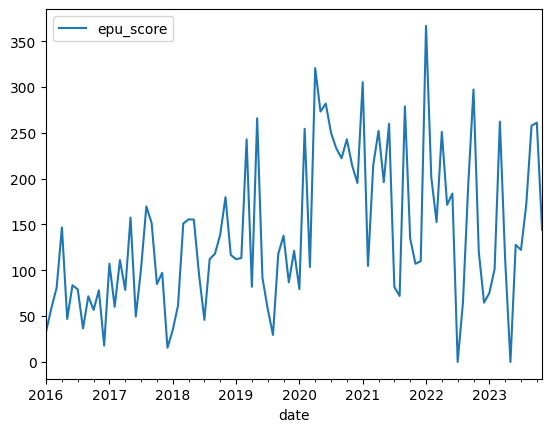

In [11]:
scaling_factor = 100/samoa_stats[samoa_stats.date < "2020-01-01"]["z_score"].mean()
samoa_stats["epu_score"] = scaling_factor * samoa_stats["z_score"]
samoa_stats.plot(x="date", y="epu_score");

In [12]:
epu_q = samoa_stats.set_index("date").groupby(pd.Grouper(freq="QS"))[["epu_score"]].sum()

In [13]:
epu_employ = epu_q.iloc[4:29]
employment_list = [
#     24375, 24381, 24694, 24904, 
    24399, 24137, 24039, 24177, 24171, 24244,
    24523, 24444, 24436, 24432, 24639, 24377, 24347, 24358, 24560, 24214,
    24220, 24261, 24504, 24134, 24087, 23995, 24454, 24269, 24811
]
epu_employ["employ"] = employment_list
epu_employ["employ_dff"] = epu_employ["employ"].diff().fillna(0)
epu_employ["ratio"] = (epu_employ["employ_dff"]/epu_employ["employ"].shift(1)) * 100
epu_employ["epu_diff"] = epu_employ["epu_score"].diff()/epu_employ["epu_score"].shift(1)

/var/folders/kn/jw0y9v615mjgg3_51g3s73zh0000gn/T/ipykernel_43078/969348967.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epu_employ["employ"] = employment_list
/var/folders/kn/jw0y9v615mjgg3_51g3s73zh0000gn/T/ipykernel_43078/969348967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epu_employ["employ_dff"] = epu_employ["employ"].diff().fillna(0)
/var/folders/kn/jw0y9v615mjgg3_51g3s73zh0000gn/T/ipykernel_43078/969348967.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

<Axes: xlabel='date'>

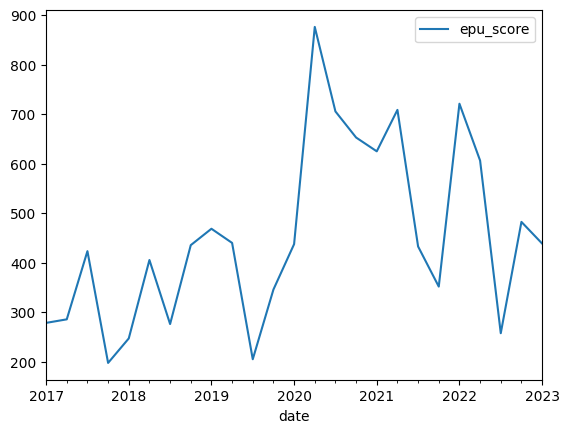

In [22]:
epu_employ.plot(y="epu_score")

In [14]:
from src.tourism.ts_utils import *

from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank

In [15]:
rank_test = select_coint_rank(epu_employ[["epu_score", "employ"]], 1, 2, method="trace",
                              signif=0.05)
rank_test.rank

2

In [16]:
max_lag = 5  # Set the maximum lag order to consider
res = select_order(epu_employ[["epu_score", "employ"]], maxlags=max_lag, deterministic='ci',
                  seasons=4)
optimal_order = res.selected_orders

# Fit VECM model with the determined order
model = VECM(epu_employ[["epu_score", "employ"]],
             k_ar_diff=1,
             coint_rank=2)  # Adjust coint_rank as needed
fitted_model = model.fit()

# Print the summary of the fitted model
print(fitted_model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation epu_score
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.epu_score    -0.0497      0.226     -0.220      0.826      -0.492       0.393
L1.employ       -0.1291      0.191     -0.675      0.499      -0.504       0.245
Det. terms outside the coint. relation & lagged endog. parameters for equation employ
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.epu_score     0.4602      0.264      1.742      0.081      -0.057       0.978
L1.employ       -0.2080      0.224     -0.930      0.353      -0.646       0.230
             Loading coefficients (alpha) for equation epu_score              
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

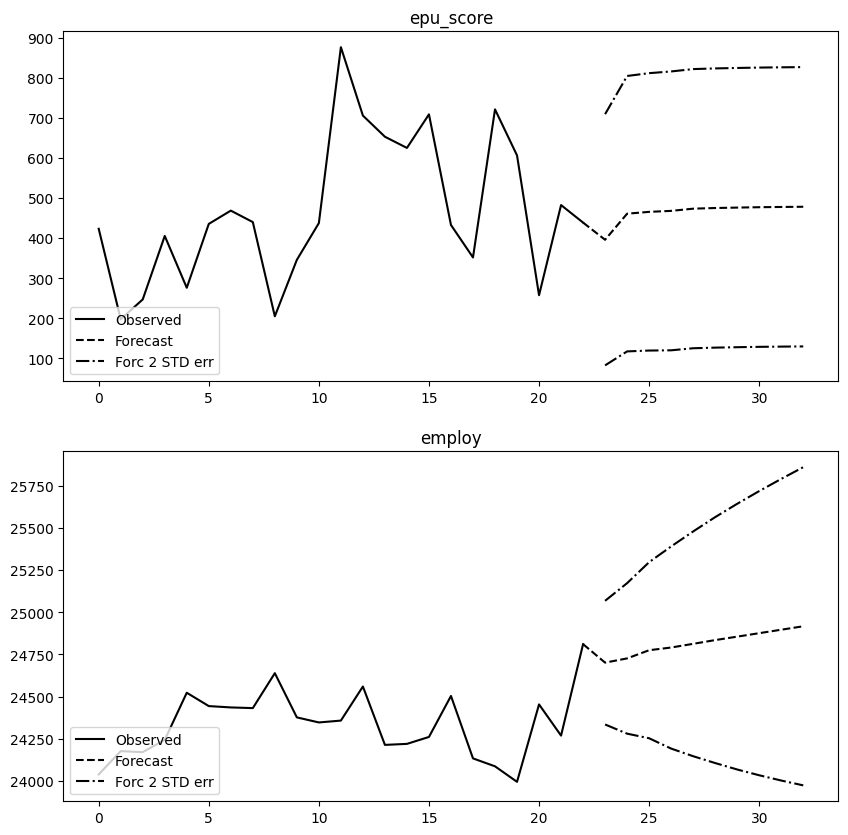

In [17]:
fitted_model.plot_forecast(steps=10)

In [18]:
get_adf_df(epu_employ.iloc[1:], ["epu_score", "employ"])

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
epu_score,-3.015978,0.033429,0.0,23.0,-3.752928,-2.998500,-2.638967
employ,0.449207,0.983245,9.0,14.0,-4.012034,-3.104184,-2.690987


In [19]:
grangers_causation_matrix(epu_employ.iloc[1:], ["ratio", "epu_diff"], maxlag=5)

,ratio_x,epu_diff_x
ratio_y,1.00000,0.0349
epu_diff_y,0.10795,1.0000


In [6]:
so = samoa.raw
so = so[(so.econ==True) & (so.policy==True)].reset_index(drop=True)

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_df = pd.DataFrame()
for row in so.news:
    sample = row.replace("\n", " ").strip()
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sample)
    ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
    sent_df = pd.concat([sent_df, ss_temp], axis=0)

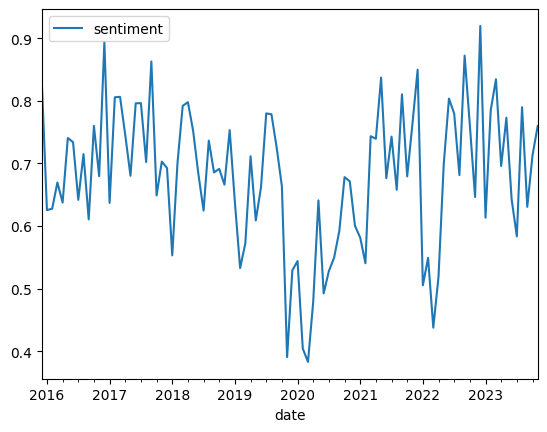

In [19]:
so["sentiment"] = sent_df["compound"].tolist()
so_sent = so.set_index("date").groupby(pd.Grouper(freq="MS"))[["sentiment"]].mean()
so_sent.plot();